# Сборный проект №2

Стартап по продаже продуктов питания, хочет разобраться, как ведут себя пользователи мобильного приложения. Дизайнеры хотят поменять шрифты во всем приложении. Решение будет принято по результатам A/A/B-теста. Пользователи разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

Цель исследования - проанализировать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки. После этого провести A/A/B-эксперимент и проанализировать его результаты.

Для проведения исследования необходимо изучить данные, сделать их предобработку, затем рассмотреть воронку событий, провести A/A/B-эксперимент и сделать выводы.

In [1]:
#Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path

from scipy import stats as st
import numpy as np
import math as mth
import  plotly.express  as  px
from  plotly  import  graph_objects  as  go

In [2]:
#Задаем размер графиков
sns.set(rc={'figure.figsize':(15,6)})

#Устанавливаем ограничения на количество знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

#Снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

#Снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# Обзор и предобработка данных

In [3]:
#Чтение файла
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('logs_exp.csv', sep='\t')

In [4]:
#Вывод информации о таблице
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
#Проверка на наличие пропусков
data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [6]:
#Проверка на наличие дубликатов
print ('Количество дублей:', data.duplicated().sum())
print ('Доля дублей в датафрейме:', '{:.1%}'.format(data.duplicated().sum()/len(data)))

Количество дублей: 413
Доля дублей в датафрейме: 0.2%


In [7]:
#Просмотр уникальных значений столбца 'EventName'
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**Вывод**

После ознакомления с данными датафрейма, можно заметить, что наименования столбцов написаны в разных регистрах. Тип данных в столбце с "временем события" является int64. В датафрейме отсутствуют пропуски, но вместе с тем имеются 413 дубликатов, что составляет 0.2% от всего датафрейма. Всего в таблице 244126 сообщений о действии пользователей, но при этом в таблице всего 5 типов событий

Для дальнейшего анализа заменим наименование столбцов, добавим столбцы с датой и временем, а также отдельный столбец дат. Также необходимо избавиться от дублей и проверить не попадают ли какие-то пользователи в несколько группы одновременно

In [8]:
#Приведение названия столбцов к "змеиному" регистру
data = data.rename(columns={'EventName' : 'event', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time', 'ExpId' : 'group'})


In [9]:
#Изменение типов данных столбца с временем события
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

#Добавление столбца с датой
data['date'] = pd.to_datetime(data['event_time'].dt.date)

#Вывод таблицы
data.head() 

,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [10]:
#Удаление дублей
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
#Проверка пользователей на попадание в несколько групп
data.groupby('user_id').agg({'group' : 'nunique'}).query('group > 1').count()

group    0
dtype: int64

In [12]:
#Вывод таблицы после предобработки
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


**Вывод**

На этапе предобработки, переименовали столбцы, заменили тип данных в столбце со временем события, добавили отдельный столбец с датой. Удалили дубли, и проверили пользователей на нахождение сразу в нескольких группах

# Изучение и проверка данных

Рассмотрим имеющиеся данные по событиям и изучим время событий. Установим имеющийся период событий и проверим полноту данных

In [13]:
#Расчет количества событей
print('Количество событий:', len(data))

Количество событий: 243713


In [14]:
#Расчет количества пользователей
print('Количество пользователей:', data['user_id'].nunique())

Количество пользователей: 7551


In [15]:
#Расчет количества событий на одного пользователя
print('Количество событий на одного пользователя:', round (len(data)/data['user_id'].nunique()))

Количество событий на одного пользователя: 32


count   7,551.000
mean       32.276
std        65.154
min         1.000
25%         9.000
50%        20.000
75%        37.000
max     2,307.000
Name: event_count, dtype: float64

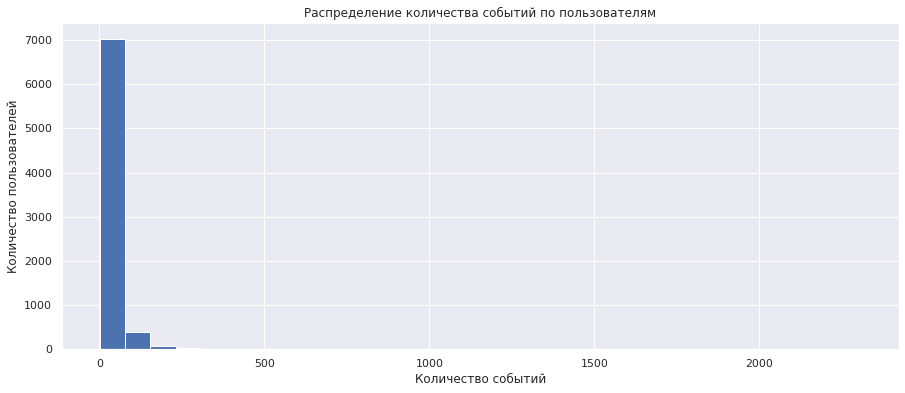

In [16]:
#Создание датафрейма по количеству событий на пользователя
events_user = data.groupby('user_id').agg(event_count = ('event', 'count')).reset_index()

#Вывод числового описания данных
display(events_user['event_count'].describe())

#Строим гистограмму
plt.hist(events_user['event_count'], bins = 30) 
plt.title('Распределение количества событий по пользователям')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод**

Среднее количество событий (32) отличается от медианного (20), т.е. на среднее значение виляют выбросы. Это подтверждается минимальным количеством событий (1) и максимальным (2 307). Таким образом, можно сказать, что есть отдельные очень большие выбросы, но как видно по гистограмме у большинства пользователей количество событий близко к среднему и медианному значению

In [17]:
#Расчет максимальной и минимальной даты события, а также определение периода событий
first_date = data['event_time'].min()
last_date = data['event_time'].max()

print('Минимальная дата события:', first_date)
print('Максимальная дата события:', last_date)
print('Период:',last_date-first_date)

Минимальная дата события: 2019-07-25 04:43:36
Максимальная дата события: 2019-08-07 21:15:17
Период: 13 days 16:31:41


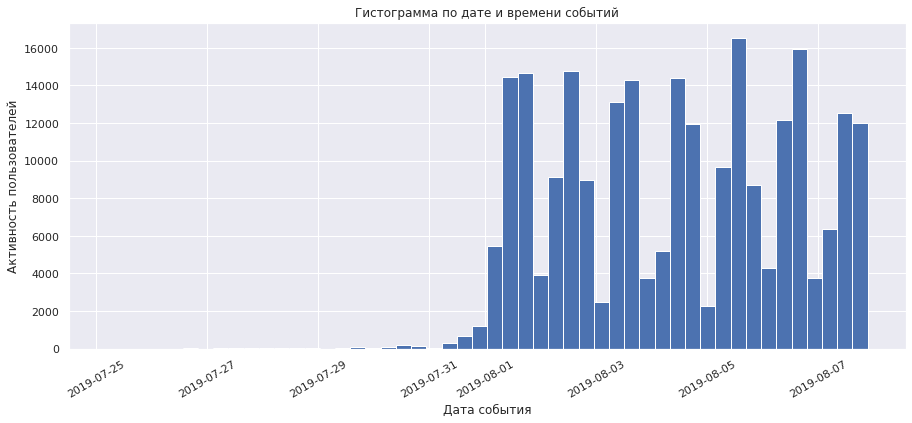

In [18]:
#Постройка гистограммы
data['event_time'].hist(bins = 50)
plt.title('Гистограмма по дате и времени событий')
plt.xlabel('Дата события')
plt.ylabel("Активность пользователей")
plt.xticks(rotation=30)
plt.show()

**Вывод**

По гистограмме видно, что за июль данные неполные. Основная активность пользователей начинается с 01.08.2019 года. Для дальнейшего анализа возьмем данные начиная с данной даты 

In [19]:
#Создание таблицы с активным периодом
data_activ = data.loc[data['date'] > '2019-07-31'] 

Проверим как изменились показатели, после определения периода исследования

In [20]:
#Расчет количества событей
print('Количество событий:', len(data_activ))

#Расчет количества пользователей
print('Количество пользователей:', data_activ['user_id'].nunique())

#Расчет количества событий на одного пользователя
print('Количество событий на одного пользователя:', round (len(data_activ)/data_activ['user_id'].nunique()))

print('Изменение количества событий:', len(data_activ) - len(data),'({:.1%})'.format((len(data_activ)-len(data))/len(data)))
print('Изменение количества пользователей:', data_activ['user_id'].nunique() - data['user_id'].nunique(),
      '({:.1%})'.format((data_activ['user_id'].nunique()-data['user_id'].nunique())/data['user_id'].nunique()))

Количество событий: 240887
Количество пользователей: 7534
Количество событий на одного пользователя: 32
Изменение количества событий: -2826 (-1.2%)
Изменение количества пользователей: -17 (-0.2%)


**Ввывод**

После определения периода исследования, количество событий сократилось на 1.2%, а количество пользователей уменьшилось на 0.2%

Проверим наличие пользователей из всех трех экспериментальных групп

In [21]:
data_activ.groupby('group').agg({'user_id': 'nunique'}) 

,user_id
group,
246,2484
247,2513
248,2537


**Вывод**

Во всех трех группах имеется сопоставимое количество пользователей

**Воронка событий**

In [22]:
#Определение частоты событий
events_group = (data_activ.groupby('event').agg({'user_id' : 'count'})
                .rename(columns={'user_id' : 'total_events'}).sort_values('total_events', ascending=False).reset_index())
events_group

,event,total_events
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


**Вывод**

После определения частоты события получили следующие результаты:

   - MainScreenAppear/Главный экран - 117328 события;
   - OffersScreenAppear/Экран предложений - 46333 события;
   - CartScreenAppear/Корзина - 42303 события;
   - PaymentScreenSuccessful/Экран оплаты - 33918 события;
   - Tutorial/Получили руководство - 1005 события.

Можно отметить, что "Получение руководства" очень сильно выделяется на фоне остальных событий из-за слишком маленького количества  

   
Посчитаем сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие

In [23]:
#Подсчет пользователей
user_group = (data_activ.groupby('event').agg({'user_id' : 'nunique'})
                .rename(columns={'user_id' : 'total_user'}).sort_values('total_user', ascending=False).reset_index())

#Расчет доли пользователей, совершивших хотя бы одно событие
user_group['share_percent'] = user_group['total_user']/data_activ['user_id'].nunique() * 100
user_group

,event,total_user,share_percent
0,MainScreenAppear,7419,98.474
1,OffersScreenAppear,4593,60.964
2,CartScreenAppear,3734,49.562
3,PaymentScreenSuccessful,3539,46.974
4,Tutorial,840,11.149


**Вывод**

После изучения пользователей и совершенных ими событий получается следующий результат:

   - MainScreenAppear/Главный экран - 7419 пользователей (98,5%);
   - OffersScreenAppear/Экран предложений - 4593 пользователя (61%);
   - CartScreenAppear/Корзина - 3734 пользователя (49,6%);
   - PaymentScreenSuccessful/Экран оплаты - 3539 пользователей (47%);
   - Tutorial/Получили руководство - 840 пользователей (11,2%)
   
Можно заметить, что у доля пользователей, совершивших первое событие (MainScreenAppear/Главный экран) составляет 98,5%, а не 100%. Это можно объяснить тем, что 1,5% пользователей установили приложение, но не пользовались им, и соответственно не видели "Главный экран"

   
По пользователям наблюдаются схожие результаты, как и с событиями. Все события выстраиваются в последовательную цепочку: **Главный экран - Экран предложений - Корзина - Экран оплаты - Получение руководства**. Все события имеют схожую динамику, за исключением последнего. Получение руководства сильно меньше остальных событий. Для расчете воронки можно исключить данное событие

In [24]:
#Исключаем событие Tutorial
user_group = user_group[user_group['event'] != 'Tutorial'].reset_index(drop= True)

Далее рассчитаем какая доля пользователей проходит на каждый следующий шаг воронки

In [25]:
#Создание сводной таблицы по пользователям
users_pivot = data.pivot_table(index='user_id',columns='event',values='event_time',aggfunc='min')

#Расчет отношения числа пользователей к предыдущему событию 
msa = users_pivot['MainScreenAppear'].count() / users_pivot['MainScreenAppear'].count() * 100
osa = users_pivot['OffersScreenAppear'].count() / users_pivot['MainScreenAppear'].count() * 100
csa = users_pivot['CartScreenAppear'].count() / users_pivot['OffersScreenAppear'].count() * 100
pss = users_pivot['PaymentScreenSuccessful'].count() / users_pivot['CartScreenAppear'].count() * 100

#Добавление столбца с долей
user_group ['share_step_percent'] = [msa, osa, csa, pss]

user_group

,event,total_user,share_percent,share_step_percent
0,MainScreenAppear,7419,98.474,100.000
1,OffersScreenAppear,4593,60.964,62.011
2,CartScreenAppear,3734,49.562,81.270
3,PaymentScreenSuccessful,3539,46.974,94.612


In [ ]:
#Расчет доли пользователей от первого события до оплаты
print ('Доля пользователей от первого события до оплаты:', 
       '{:.1%}'.format(users_pivot['PaymentScreenSuccessful'].count() / users_pivot['MainScreenAppear'].count()))

In [ ]:
#Строим график по Воронке событий
fig = go.Figure(go.Funnel(y = user_group['event'],
                          x = user_group['total_user'],
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий')
fig.show()

**Вывод**

После рассчета доли пользователей к предыдущему событию, можно заметить, что больше всего пользователей теряется после первого шага - 38%.  Доля пользователей от первого события до оплаты составляет - 47.7%, т.е. конверсия составляет практически 50%.

# Анализ результатов эксперимента

Для проведения A/A/B-эксперимента пользователи разбиты на 3 группы, 246 и 247 — контрольные группы (A/A), а 248 — экспериментальная (B)

Посмотрим количество пользователя в каждой группе

In [ ]:
data_activ.groupby('group').agg({'user_id': 'nunique'}) 

Создадим датафрейм по событиям, группам и количеству пользователей

In [ ]:
#Создание датафрейма
funnel_group = (data.groupby(['event', 'group']).agg({'user_id': 'nunique'}).
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False).reset_index())

funnel_group = funnel_group[funnel_group['event'] != 'Tutorial']
funnel_group

Проверим находят ли статистические критерии разницу между выборками 246 и 247 (контрольные группы A/A). Используем для этого гипотезу о равенстве долей. Для этого объявим функцию, которая будет производить расчет и сравнение гипотез, а затем через цикл проведем сравнение по событиям

In [ ]:
#Создание функции
def test(data_1,data_2, event, alpha):
    
    # число пользователей, по событиям в группе 1 и группе 2
    event_user = np.array([data_1[data_1['event'] == event]['user_id'].nunique(),
                           data_2[data_2['event'] == event]['user_id'].nunique()])
    
    # число пользователей в группе 1 и группе 2:
    all_user = np.array([data_1['user_id'].nunique(),data_2['user_id'].nunique()])
    
    
    # пропорция успехов в первой группе:
    p1 = event_user[0]/all_user[0]

    # пропорция успехов во второй группе:
    p2 = event_user[1]/all_user[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (event_user[0] + event_user[1])/(all_user[0] + all_user[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_user[0] + 1/all_user[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    #тест двусторонний, удваиваем результат
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    #Вывод результатов
    print('Событие:', event)
    print('p-значение: ', '{:.3}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Сопоставим доли по каждому событию между группами 246 и 247

Сформулируем гипотезы:

Нулевая гипотеза - доли пользователей по событиям одинаковые

Альтернативная гипотеза - доли пользователей по событиям отличаются

In [ ]:
#Расчет статистически значимой разницы между контрольными группами 246 и 247:
for event in funnel_group['event'].unique():
    test(data_activ[data_activ['group'] == 246], data_activ[data_activ['group'] == 247], event,.05)
    print()

**Вывод**

Между группами 246 и 247 статистические критерии не показали разницу. Таким образом по результатам A/A-теста можно сделать вывод, что выбранные группы для проведения эксперимента отобраны корректно и можно проводить A/B-тест

Проведем расчет статистически значимой разницы между контрольными группами (246,247) и экспериментальной группой с измененным шрифтом (248)

Сформулируем гипотезы:

Нулевая гипотеза - доли пользователей по событиям одинаковые

Альтернативная гипотеза - доли пользователей по событиям отличаются

In [ ]:
#Расчет статистически значимой разницы между контрольными группами 246 и 248:
for event in funnel_group['event'].unique():
    test(data_activ[data_activ['group'] == 246], data_activ[data_activ['group'] == 248], event,.05)
    print()

**Вывод**

Между группами 246 и 248 статистические критерии не показали разницу, т.е. оснований считать группы разными нет

In [ ]:
#Расчет статистически значимой разницы между контрольными группами 247 и 248:
for event in funnel_group['event'].unique():
    test(data_activ[data_activ['group'] == 247], data_activ[data_activ['group'] == 248], event,.05)
    print()

**Вывод**

Между группами 247 и 248 статистические критерии не показали разницу, т.е. оснований считать группы разными нет

In [ ]:
#Расчет статистически значимой разницы между объединенной контрольной группой и экспериментальной:
for event in funnel_group['event'].unique():
    test(data_activ[data_activ['group'] != 248], data_activ[data_activ['group'] == 248], event,.05)
    print()

**Вывод**

По результатам сравнения объединенной контрольной группой и экспериментальной получился такой же результат, как и после сравнения групп по отдельности, т.е. можно сделать вывод, что изменение шрифта не повлияло на поведение пользователей

**Уровень значимости**

Был проведен множественный тест, соответственно чем больше групп, тем больше вероятность ошибки первого рода. В нашем проекте 3 группы, выбранный уровень значимости - 0.05. Рассчитаем вероятность ошибки первого рода по вормуле `1-(1-alpha)**n` 

In [ ]:
print ( '{:.1%}'.format(1-(1-.05)**3))

Вероятность ошибки первого рода составляет - 14.3%. Вероятность ошибки выше чем выбранный уровень значимости. Для снижения вероятности ложнопозитивного результата применим поправку Бонферрони, т.е. поделить выбранный уровень значимости на число проверенных гипотез - 16. Рассчитаем вероятность ошибки первого рода с откорректированным уровнем значимости после применения поправки Бонферрони - `alpha/m`, где m - количество эксперементов

In [ ]:
print ( '{:.1%}'.format(1-(1-.05/16)**3))

**Вывод**

После применения поправки Бонферрони, вероятность ошибки первого рода составила - 0,009, что меньше, чем выбранный ранее уровень значимости 0.05. Таким образом оснований для проведения повторного теста не имеется, результаты подсчитаны корректно

# Общий вывод

После проведения предобработки и изучения предоставленных данных было установлено, что в данных содержится информация о 5 типах событий, которые были совершены в период с 01/08/2019 по 07/08/2019.

После изучения пользователей и совершенных ими событий получается следующий результат:

   - MainScreenAppear/Главный экран - 7419 пользователей (36,9%);
   - OffersScreenAppear/Экран предложений - 4593 пользователя (22.8%);
   - CartScreenAppear/Корзина - 3734 пользователя (18.6%);
   - PaymentScreenSuccessful/Экран оплаты - 3539 пользователей (17,6%);
   - Tutorial/Получили руководство - 840 пользователей (4.2%)

После изучения пользователей и совершенных ими событий получается следующий результат:

   - MainScreenAppear/Главный экран - 7419 пользователей (98,5%);
   - OffersScreenAppear/Экран предложений - 4593 пользователя (61%);
   - CartScreenAppear/Корзина - 3734 пользователя (49,6%);
   - PaymentScreenSuccessful/Экран оплаты - 3539 пользователей (47%);
   - Tutorial/Получили руководство - 840 пользователей (11,2%)

Все события выстраиваются в цепочку **Главный экран - Экран предложений - Корзина - Экран оплаты - Получение руководства** Для дальнейшего изучения было решено исключить событие "Tutorial/Получили руководство", т.к. данное событие сильно выделяется на фоне остальных из-за своей малочисленности.

Далее было установлено, что больше всего пользователей теряется после первого шага (Главный экран) - 38%. Доля пользователей от просмотра Главного экрана, до оплативших заказ составляет - 47.7%.

Далее был проведен A/A/B эксперимент для установления влияния измененного шрифта на поведение пользователей. Пользователи были разбиты на 3 группы: 2 контрольные со старыми шрифтами (246 и 247) и одну экспериментальную — с новыми (248). Количество пользователей по группам составило 246 - 2484 пользователя, 247 - 2513 пользователя, 248 - 2537 пользователя. Были сопоставлены доли пользователей по каждому событию сначала между контрольными группами, а затем в сравнении с экспериментальной, в том числе и единая объеденная группа. По результатам всех проведенных тестов статистически значимая разница между группами не была обнаружена, таким образом можно сделать вывод, что изменение шрифта в приложении никак не повлияло на поведение пользователей.



